# Topic Modeling Tutorial
https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [1]:
# !pip install gensim==3.8.3

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# NTLK stopwords
from nltk.corpus import stopwords

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import pickle 

import warnings
warnings.filterwarnings("ignore")

In [3]:
#update stopwords 
stop_words = stopwords.words('english')
stop_words.extend(['use', 'used', 'using', 'one', 'like', 'user', 'make', 'also', 'get', 'point', 'let', 'go'])

In [4]:
filename = 'data/cleaned_no_outliers.csv'
output_filename = 'data/spacy_preprocess.csv'

In [5]:
df = pd.read_csv(filename)

In [6]:
#remove non-text, non-Y columns
df = df.drop(columns=['date', 'responses', 'author_url',
       'story_url', 'reading_time (mins)', 'number_sections', 
       'number_paragraphs'])

#### Combine Title & Subtitle

In [7]:
df['combined_title'] = (df['title'] + ' ' + df['subtitle'])

In [8]:
df = df.drop(columns = ['title', 'subtitle']).reset_index(drop=True)

#### Remove Punctuation & Make Lowercase

In [9]:
text_cols = ['section_titles', 'paragraphs', 'combined_title']

In [10]:
for col in text_cols:
    df[col] = df[col].map(lambda x: re.sub("[''·,\.!?'-]", '', x).lower())

#### Remove the 'Min Read' Phrase at the Beginning of Each Paragraph

In [11]:
#remove all text up to and including 'min read' in the beginning of the paragraphs
df['paragraphs'] = df['paragraphs'].map(lambda x: (x[x.index('min read')+9:] if (x.count('min read') > 0) else x))
                     

#### Remove the Brackets Surrounding The Section Titles

In [12]:
#remove brackets surrounding the section titles
df['section_titles'] = df['section_titles'].map(lambda x: x.replace("[",""))
df['section_titles'] = df['section_titles'].map(lambda x: x.replace("]",""))

#### Combine Text Columns

In [13]:
df['text'] = df['combined_title'] + df['section_titles'] + df['paragraphs']

In [14]:
df = df.drop(columns = ['section_titles', 'paragraphs', 'combined_title'])

In [15]:
# Convert to list
data = df['text'].values.tolist()

#### Tokenize Words and Clean Up Text

In [16]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) 

data_words = list(sent_to_words(data))

#### Bigram and Trigram Models

In [17]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [18]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

#### Remove Stop Words 

In [19]:
data_words_nostops = remove_stopwords(data_words)

#### Form Bigrams

In [20]:
data_words_bigrams = make_bigrams(data_words_nostops)

#### Initialize Spacy 'en' Model

In [21]:
#!spacy download en_core_web_lg

In [22]:
nlp = spacy.load('en_core_web_lg')

#### Lemmatize

In [23]:
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV','PROPN'])

#### Create the Dictionary & Corpus Needed for Topic Modeling

In [24]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [25]:
#check out the dictionary

id2word[0]

'abbreviate'

In [26]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('abbreviate', 1),
  ('ability', 1),
  ('able', 2),
  ('ace', 5),
  ('achieve', 1),
  ('actual', 1),
  ('adapt', 1),
  ('addition', 1),
  ('additional', 1),
  ('aim', 1),
  ('airbnb', 1),
  ('algorithm', 5),
  ('allow', 1),
  ('always', 1),
  ('amazon', 1),
  ('amount', 1),
  ('analysis', 1),
  ('analytic', 1),
  ('answer', 3),
  ('appear', 5),
  ('apply', 4),
  ('approach', 3),
  ('approximate', 1),
  ('article', 1),
  ('ask', 7),
  ('aspect', 1),
  ('assumption', 2),
  ('base', 2),
  ('basic', 5),
  ('begin', 1),
  ('benefit', 1),
  ('best_practice', 1),
  ('book', 1),
  ('breadthfirst_search', 1),
  ('business', 3),
  ('candidate', 9),
  ('capability', 1),
  ('career', 1),
  ('carry', 1),
  ('catch', 1),
  ('categorization', 1),
  ('categorize', 3),
  ('category', 3),
  ('chance', 1),
  ('check', 2),
  ('choice', 3),
  ('choose', 1),
  ('clarify', 1),
  ('classic', 1),
  ('clearly', 2),
  ('code', 45),
  ('coderpad', 1),
  ('codesignal', 1),
  ('coding', 7),
  ('collection', 1),
 

### Build the LDA Model

In [27]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [28]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.051*"code" + 0.049*"python" + 0.019*"library" + 0.016*"language" + '
  '0.014*"package" + 0.010*"machine" + 0.009*"write" + 0.009*"spark" + '
  '0.008*"tool" + 0.008*"learn"'),
 (1,
  '0.020*"file" + 0.018*"create" + 0.017*"run" + 0.009*"code" + 0.009*"api" + '
  '0.008*"follow" + 0.008*"need" + 0.008*"step" + 0.008*"see" + '
  '0.007*"command"'),
 (2,
  '0.049*"word" + 0.034*"text" + 0.014*"sentence" + 0.013*"tweet" + '
  '0.012*"language" + 0.012*"nlp" + 0.012*"document" + 0.012*"topic" + '
  '0.011*"sentiment" + 0.009*"character"'),
 (3,
  '0.024*"function" + 0.015*"value" + 0.013*"probability" + 0.011*"number" + '
  '0.010*"state" + 0.010*"matrix" + 0.009*"algorithm" + 0.008*"example" + '
  '0.008*"node" + 0.007*"vector"'),
 (4,
  '0.037*"image" + 0.032*"model" + 0.015*"network" + 0.014*"training" + '
  '0.014*"layer" + 0.012*"learning" + 0.012*"deep" + 0.012*"train" + '
  '0.011*"input" + 0.010*"learn"'),
 (5,
  '0.022*"datum" + 0.014*"science" + 0.012*"work" + 0.011*"le

### Compute Model Perplexity and Coherence Score

In [29]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.27062167756744

Coherence Score:  0.46932601573889443


### Visualize

In [30]:
pyLDAvis.enable_notebook()
plot = gensimvis.prepare(lda_model, corpus, id2word)
# Save pyLDA plot as html file
pyLDAvis.save_html(plot, 'figures/LDA_spacy_TDS10.html')

In [31]:
plot

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.053070  0.064854       1        1  21.089095
9     -0.003324 -0.095812       2        1  11.245254
8     -0.071280  0.215133       3        1  10.951520
7      0.106432  0.083936       4        1  10.543168
3      0.069826 -0.043423       5        1  10.360976
1     -0.167463 -0.122409       6        1   9.667237
6      0.206493  0.049995       7        1   9.283696
4      0.039046  0.083243       8        1   8.647951
0     -0.253077 -0.021758       9        1   4.407662
2      0.126417 -0.213758      10        1   3.803441, topic_info=           Term          Freq         Total Category  logprob  loglift
241       model  60098.000000  60098.000000  Default  30.0000  30.0000
81        datum  87199.000000  87199.000000  Default  29.0000  29.0000
50         code  24273.000000  24273.000000  Default  28.0000  28.0000
286      python  18126.000000  18126.000000  Default  27.0000  27.0000
932       image  18894.000000  18894.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
35    candidate    979.925887   2405.376490  Topic10  -5.3149   2.3713
136        find   1268.524359  18509.285881  Topic10  -5.0568   0.5888
1064     filter   1017.720854   3751.742615  Topic10  -5.2771   1.9646
27         base   1065.474445  10705.687237  Topic10  -5.2312   0.9619
23      article   1022.294951  17473.236985  Topic10  -5.2726   0.4306

[761 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
18102     10  0.998342  accent
1540       1  0.014089  access
1540       2  0.150981  access
1540       3  0.324463  access
1540       5  0.000421  access
...      ...       ...     ...
413        1  0.667028    year
413        2  0.097303    year
413        3  0.097674    year
413        7  0.137486    year
413        8  0.000495    year

[1928 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 10, 9, 8, 4, 2, 7, 5, 1, 3])

#### Build LDA Mallet Model

In [32]:
import os
os.environ.update({'/Users/rachelinsler/dsi/downloads/mallet-2.0.8/bin/':r'Python/Mallet/mallet-2.0.8/bin'})

In [33]:
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec
from gensim.models.wrappers import LdaMallet

In [34]:
mallet_path = '/Users/rachelinsler/dsi/downloads/mallet-2.0.8/bin/mallet' # update this path
ldamallet = LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

In [35]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('datum', 0.0210006302636705),
   ('model', 0.02015619932649494),
   ('variable', 0.017822795963864883),
   ('distribution', 0.015065137444392999),
   ('feature', 0.014600088522470226),
   ('test', 0.01398002329323986),
   ('probability', 0.012174899188408044),
   ('sample', 0.010761395228353298),
   ('time', 0.009178597143212631),
   ('number', 0.008542214407949889)]),
 (1,
  [('code', 0.030109975673480043),
   ('file', 0.02405422496067475),
   ('create', 0.02350513422343042),
   ('python', 0.019548980469022505),
   ('run', 0.015885375058228374),
   ('project', 0.011440890607172835),
   ('follow', 0.011042574785483301),
   ('package', 0.010466479585751545),
   ('app', 0.0090194904708003),
   ('add', 0.008825958489640413)]),
 (2,
  [('word', 0.030945964136477287),
   ('text', 0.020492214104256824),
   ('language', 0.010488118525477078),
   ('model', 0.00852911440985001),
   ('topic', 0.008503338039907549),
   ('document', 0.008317175368100883),
   ('sentence', 0.007818832215879

#### Compute Optimal Number of Topics

In [67]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [68]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=4, limit=20, step=2)


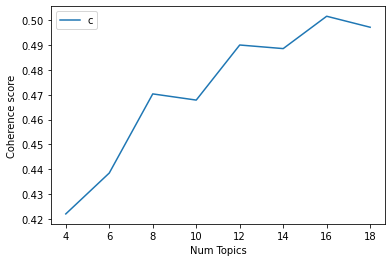

In [69]:
# Show graph
limit=20; start=4; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

### Create Model with Optimal Number of Topics

In [95]:
ldamallet = LdaMallet(mallet_path, corpus=corpus, num_topics=16, id2word=id2word,
                     iterations=2000,
                      topic_threshold=0.1,
                      random_seed=42,)

In [96]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.48637047361746505


In [97]:
# the pyLDAvis was throwing errors on the mallet model; so I found this code on stackoverflow: https://stackoverflow.com/questions/54684552/issue-with-topic-word-distributions-after-malletmodel2ldamodel-in-gensim
from gensim.models.ldamodel import LdaModel

def ldaMalletConvertToldaGen(mallet_model):
    model_gensim = LdaModel(id2word=mallet_model.id2word, num_topics=mallet_model.num_topics, alpha=mallet_model.alpha, eta=0, iterations=1000, gamma_threshold=0.001, dtype=np.float32)
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

converted_model = ldaMalletConvertToldaGen(ldamallet)

In [98]:
pyLDAvis.enable_notebook()
plot = gensimvis.prepare(converted_model, corpus, id2word, sort_topics=False)
# Save pyLDA plot as html file
pyLDAvis.save_html(plot, 'figures/LDA_mallet_16.html')

In [99]:
plot

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0     -0.102603  0.109856       1        1  6.408067
1      0.220774  0.000740       2        1  6.619354
2     -0.142835  0.058636       3        1  6.461748
3     -0.109275 -0.043306       4        1  4.855587
4     -0.045686 -0.293722       5        1  7.105840
5      0.101367 -0.178470       6        1  5.950229
6     -0.119321  0.106559       7        1  8.097678
7      0.192485 -0.079571       8        1  7.627595
8      0.105001  0.163825       9        1  5.170215
9      0.213698  0.045977      10        1  6.261719
10    -0.191187 -0.150693      11        1  5.975566
11    -0.138858 -0.052881      12        1  6.095441
12     0.140301 -0.048790      13        1  7.325993
13    -0.088644  0.195384      14        1  6.730986
14    -0.103674  0.017174      15        1  5.105711
15     0.068457  0.149281      16        1  4.208271, topic_info=          Term          Freq         Total Category  logprob  loglift
241      model  65682.000000  65682.000000  Default  30.0000  30.0000
81       datum  95495.000000  95495.000000  Default  29.0000  29.0000
926   function  29360.000000  29360.000000  Default  28.0000  28.0000
932      image  19297.000000  19297.000000  Default  27.0000  27.0000
317    science  17246.000000  17246.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
753     result   1351.579996  18244.075691  Topic16  -5.0945   0.5656
1079     point   1047.297528   6698.411955  Topic16  -5.3496   1.3125
61     compare    970.637245   6274.323431  Topic16  -5.4256   1.3019
27        base   1028.427393  11650.143135  Topic16  -5.3678   0.7408
654       make   1026.068523  13194.979694  Topic16  -5.3700   0.6140

[1532 rows x 6 columns], token_table=       Topic      Freq                Term
term                                      
2902       9  1.004529              abroad
418       10  1.027712             acclaim
1113       3  0.113476            accuracy
1113       7  0.886551            accuracy
2289       1  0.658321              action
...      ...       ...                 ...
3614       9  0.979416  yearly_seasonality
13006      3  1.000630                yolo
17707      3  0.999911               yolov
1328       7  1.075423              youden
7900       1  1.036531               y₁_y₂

[3422 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])

This doesn't look great. There was a local coherence maximum at 8 topics, which also makes a bit more sense visually - I will try that next. 

In [100]:
ldamallet = LdaMallet(mallet_path, corpus=corpus, num_topics=8, id2word=id2word,
                     iterations=2000,
                      topic_threshold=0.1,
                      random_seed=42,)

In [101]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.46265765796982483


In [102]:
def ldaMalletConvertToldaGen(mallet_model):
    model_gensim = LdaModel(id2word=mallet_model.id2word, num_topics=mallet_model.num_topics, alpha=mallet_model.alpha, eta=0, iterations=1000, gamma_threshold=0.001, dtype=np.float32)
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

converted_model = ldaMalletConvertToldaGen(ldamallet)

In [103]:
pyLDAvis.enable_notebook()
plot = gensimvis.prepare(converted_model, corpus, id2word, sort_topics=False)
# Save pyLDA plot as html file
pyLDAvis.save_html(plot, 'figures/LDA_mallet_8.html')

In [104]:
plot

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.126736 -0.233278       1        1  12.587259
1     -0.136793  0.131793       2        1  12.255553
2      0.288874  0.009783       3        1  12.084253
3     -0.196723  0.097882       4        1  14.932968
4     -0.031103  0.034710       5        1   9.053166
5      0.051602  0.024307       6        1  11.070011
6      0.048025 -0.208357       7        1  16.889514
7      0.102854  0.143160       8        1  11.127275, topic_info=         Term          Freq         Total Category  logprob  loglift
81      datum  95402.000000  95402.000000  Default  30.0000  30.0000
241     model  66421.000000  66421.000000  Default  29.0000  29.0000
926  function  29600.000000  29600.000000  Default  28.0000  28.0000
50       code  26573.000000  26573.000000  Default  27.0000  27.0000
932     image  19449.000000  19449.000000  Default  26.0000  26.0000
..        ...           ...           ...      ...      ...      ...
378      time   4545.181598  29301.350993   Topic8  -4.8541   0.3322
23    article   3740.510304  18981.698896   Topic8  -5.0489   0.5715
136      find   3511.923582  20156.377483   Topic8  -5.1120   0.4484
326       set   3470.362211  19722.011243   Topic8  -5.1239   0.4583
292      read   3160.962105  10328.647410   Topic8  -5.2173   1.0117

[753 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
416       5  0.965909    abcd
1540      1  0.089635  access
1540      3  0.661083  access
1540      6  0.020476  access
1540      7  0.066443  access
...     ...       ...     ...
413       1  0.408001    year
413       6  0.218714    year
413       7  0.373305    year
1801      4  0.885896   ymean
1328      4  1.063075  youden

[1341 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8])

In [105]:
ldamallet = LdaMallet(mallet_path, corpus=corpus, num_topics=7, id2word=id2word,
                     iterations=2000,
                      topic_threshold=0.1,
                      random_seed=42,)

In [106]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4517178334413203


In [107]:
def ldaMalletConvertToldaGen(mallet_model):
    model_gensim = LdaModel(id2word=mallet_model.id2word, num_topics=mallet_model.num_topics, alpha=mallet_model.alpha, eta=0, iterations=1000, gamma_threshold=0.001, dtype=np.float32)
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

converted_model = ldaMalletConvertToldaGen(ldamallet)

In [108]:
pyLDAvis.enable_notebook()
plot = gensimvis.prepare(converted_model, corpus, id2word, sort_topics=False)
# Save pyLDA plot as html file
pyLDAvis.save_html(plot, 'figures/LDA_mallet_7.html')

In [109]:
plot

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.124661 -0.151498       1        1  13.892617
1      0.096815 -0.175554       2        1  13.841435
2      0.282299 -0.059253       3        1  13.648667
3      0.081362  0.200463       4        1  16.738040
4     -0.071591  0.154058       5        1  12.915764
5     -0.190580 -0.101742       6        1  16.475737
6     -0.073645  0.133525       7        1  12.487739, topic_info=          Term          Freq         Total Category  logprob  loglift
241      model  66336.000000  66336.000000  Default  30.0000  30.0000
81       datum  95687.000000  95687.000000  Default  29.0000  29.0000
926   function  29235.000000  29235.000000  Default  28.0000  28.0000
932      image  19458.000000  19458.000000  Default  27.0000  27.0000
317    science  17342.000000  17342.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
969     people   2406.180770   8119.592693   Topic7  -5.6054   0.8642
1095    series   2139.974702   5685.098839   Topic7  -5.7227   1.1034
61     compare   2117.025885   6251.370829   Topic7  -5.7335   0.9976
210      level   2097.519527   6211.860853   Topic7  -5.7427   0.9947
178    include   2114.731064   8850.470395   Topic7  -5.7346   0.6489

[696 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
416       7  0.980444    abcd
1540      2  0.147210  access
1540      3  0.674033  access
1540      4  0.050949  access
1540      5  0.088535  access
...     ...       ...     ...
413       4  0.393108    year
413       5  0.025638    year
413       7  0.581117    year
1801      6  0.884486   ymean
1328      6  1.061383  youden

[1206 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7])

In [110]:
ldamallet = LdaMallet(mallet_path, corpus=corpus, num_topics=6, id2word=id2word,
                     iterations=2000,
                      topic_threshold=0.1,
                      random_seed=42,)

In [111]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.44274751025287745


In [112]:
def ldaMalletConvertToldaGen(mallet_model):
    model_gensim = LdaModel(id2word=mallet_model.id2word, num_topics=mallet_model.num_topics, alpha=mallet_model.alpha, eta=0, iterations=1000, gamma_threshold=0.001, dtype=np.float32)
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

converted_model = ldaMalletConvertToldaGen(ldamallet)

In [113]:
pyLDAvis.enable_notebook()
plot = gensimvis.prepare(converted_model, corpus, id2word, sort_topics=False)
# Save pyLDA plot as html file
pyLDAvis.save_html(plot, 'figures/LDA_mallet_6.html')

In [114]:
plot

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.135806 -0.126141       1        1  17.764638
1      0.086687 -0.173391       2        1  15.272730
2      0.277444 -0.022727       3        1  15.019387
3      0.044840  0.246417       4        1  20.870050
4     -0.195641  0.008164       5        1  16.930412
5     -0.077524  0.067679       6        1  14.142782, topic_info=          Term          Freq         Total Category  logprob  loglift
241      model  66229.000000  66229.000000  Default  30.0000  30.0000
926   function  29322.000000  29322.000000  Default  29.0000  29.0000
81       datum  95499.000000  95499.000000  Default  28.0000  28.0000
932      image  19434.000000  19434.000000  Default  27.0000  27.0000
50        code  26413.000000  26413.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
1105      task   2829.069406   9917.041258   Topic6  -5.5680   0.7017
753     result   3168.327625  18205.510712   Topic6  -5.4547   0.2074
141     follow   2946.372358  19896.189193   Topic6  -5.5274   0.0460
27        base   2697.966168  11649.780973   Topic6  -5.6154   0.4932
1003      step   2651.964983  15012.860143   Topic6  -5.6326   0.2224

[576 rows x 6 columns], token_table=      Topic      Freq               Term
term                                    
1330      1  1.004942  abstract_painting
1540      2  0.154144             access
1540      3  0.700937             access
1540      4  0.144978             access
418       4  1.035739            acclaim
...     ...       ...                ...
1325      5  0.877318     wwwicunicampbr
413       2  0.081816               year
413       4  0.589053               year
413       5  0.329195               year
1328      1  1.064057             youden

[902 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6])